In [27]:
import cv2
import numpy as np
import matplotlib.ticker as tic
from prettytable import PrettyTable
from matplotlib import pyplot as plt
from skimage import io, util, filters, metrics
from numba  import jit

In [28]:
# Формирование исходного сигнала
def signal(x):
    return 0.5 + 0.5*np.sin(frequency * x + phase)

In [29]:
def showImages(*args):
    fig, axes = plt.subplots(1, len(args))

    for i in range(len(axes)):
        axes[i].imshow(args[i], cmap="gray")
        axes[i].axis("off")

    fig.set_figwidth(10)
    fig.set_figheight(10)
    plt.show()

In [30]:
counts_num = 50

# Функция дискретизации
def sampling(s_frequancy):
    out = []
    x = 0
    while x < counts_num:
        y = signal(x)
        y1 = signal(x + s_frequancy)
        out.append(round((y + y1) / 2, 2))
        x += s_frequancy
    return np.array(out)

In [31]:
# Изменение размера - интерполяция методом ближайшего соседа
def interpolation(img, size):
    out = cv2.resize(img, size, cv2.INTER_NEAREST)
    return out

In [32]:
# Преобразование дискретных значений в изображение
def createImage(row):
    row = np.around(255 * row)
    image = np.full((row.size, row.size), row)
    return image

In [33]:
# Функция квантования изображения
def quantization (image, low, high, l_num):
    levels = [] #Уровни квантования
    while low <= high:
        levels.append(low)
        low += 1/l_num

    for i in range(len(image)):
        for j in range(len(image[i])):
            for k in range(len(levels)):
                if image[i][j] < levels[k]:
                    if image[i][j] < (levels[k-1] + levels[k]) / 2:
                        image[i][j] = levels[k-1]
                        break
                    else:
                        image[i][j] = levels[k]
                        break
    return image

In [34]:
# Случайный дизеринг
def random_dither(img):
    out = np.zeros(img.shape, dtype=np.uint8)
    noise = np.zeros(img.shape, dtype=np.uint8)
    noise = util.random_noise(noise, "gaussian", 3)

    for i in range(len(img)):
        for j in range(len(img[i])):
            if img[i][j] >= noise[i][j]:
                out[i][j] = 255
            else:
                out[i][j] = 0

    return out

In [35]:
# Упорядоченный дизеринг
def control_dither(img):
    out = np.zeros(img.shape, dtype=np.uint8)

    for i in range(0, len(img), 2):
        for j in range(0, len(img[i]), 2):
            if i + 2 >= len(img) or j + 2 >= len(img[i]): break
            mean = np.around((img[i][j] + img[i+1][j] + img[i][j+1] + img[i+1][j+1]) / 4, 2)
            if mean <= 0.25:
                out[i][j] = out[i+1][j] = out[i][j+1] = out[i+1][j+1] = 0
            elif mean > 0.25 and mean <= 0.5:
                out[i][j] = 1
                out[i+1][j] = out[i][j+1] = out[i+1][j+1] = 0
            elif mean > 0.5 and mean <= 0.75:
                out[i][j] = out[i+1][j+1] = 1
                out[i+1][j] = out[i][j+1] = 0
            elif mean > 0.75 and mean <= 1:
                out[i][j] = out[i+1][j] = out[i][j+1] = out[i+1][j+1] = 1

    return out

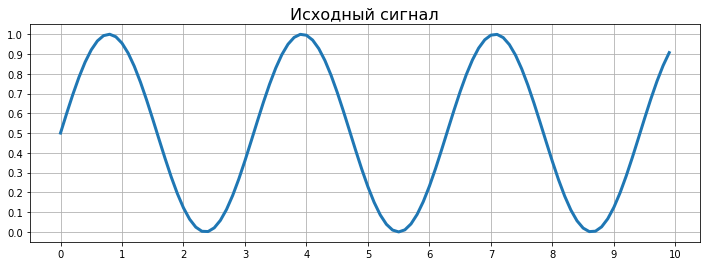

In [36]:
#@title #**Параметры сигнала** { run: "auto" }
frequency =  2#@param {type:"number"}
phase = 0 #@param ["0", "np.pi/4", "np.pi/2", "np.pi", "(np.pi * 3)/2"] {type:"raw"}

#функция генерации сигнала
x = np.arange(0, 10, 0.1)
y = 0.5 + 0.5*np.sin(frequency * x + phase)

fig, ax = plt.subplots()
ax.plot(x, y, linewidth = 3)

#Устанавливаем интервал основных делений:
ax.xaxis.set_major_locator(tic.MultipleLocator(1))
ax.yaxis.set_major_locator(tic.MultipleLocator(0.1))

fig.set_figwidth(12)
fig.set_figheight(4)
plt.title("Исходный сигнал", fontsize=16)
plt.grid()
plt.show()

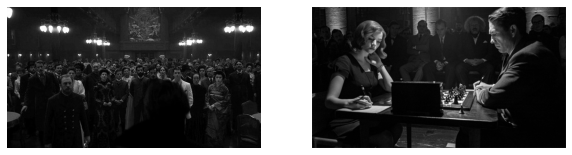

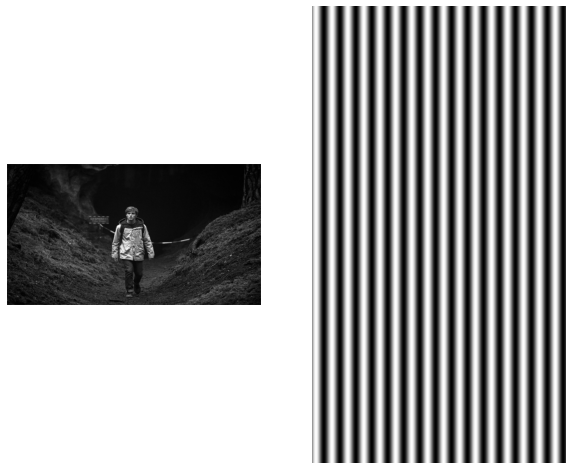

In [37]:
img1 = io.imread("1.jpg", True)
img2 = io.imread("2.jpg", True)
img3 = io.imread("3.jpg", True)
img4 = interpolation(createImage(sampling(0.1)), img1.shape)

showImages(img1, img2)
showImages(img3, img4)

In [38]:
# Квантование изображений
img1_q2 = quantization(img1.copy(), 0, 1, 2)
img1_q4 = quantization(img1.copy(), 0, 1, 4)
img1_q16 = quantization(img1.copy(), 0, 1, 16)
img1_q64 = quantization(img1.copy(), 0, 1, 64)
img1_q128 = quantization(img1.copy(), 0, 1, 128)

img2_q2 = quantization(img2.copy(), 0, 1, 2)
img2_q4 = quantization(img2.copy(), 0, 1, 4)
img2_q16 = quantization(img2.copy(), 0, 1, 16)
img2_q64 = quantization(img2.copy(), 0, 1, 64)
img2_q128 = quantization(img2.copy(), 0, 1, 128)

img3_q2 = quantization(img3.copy(), 0, 1, 2)
img3_q4 = quantization(img3.copy(), 0, 1, 4)
img3_q16 = quantization(img3.copy(), 0, 1, 16)
img3_q64 = quantization(img3.copy(), 0, 1, 64)
img3_q128 = quantization(img3.copy(), 0, 1, 128)

img4_q2 = quantization(img4.copy(), 0, 1, 2)
img4_q4 = quantization(img4.copy(), 0, 1, 4)
img4_q16 = quantization(img4.copy(), 0, 1, 16)
img4_q64 = quantization(img4.copy(), 0, 1, 64)
img4_q128 = quantization(img4.copy(), 0, 1, 128)

In [39]:
img1_rd = random_dither(img1)
img1_cd = control_dither(img1)

img2_rd = random_dither(img2)
img2_cd = control_dither(img2)

img3_rd = random_dither(img3)
img3_cd = control_dither(img3)

img4_rd = random_dither(img4)
img4_cd = control_dither(img4)

In [40]:
def count_metrics(*args, deffault_img):
    MSE = []
    PSNR = []
    SSIM = []
    table = PrettyTable()
    table.field_names = ["№", "Изображение", "MSE", "PSNR", "SSIM"]

    deffault_img = np.around(255 * deffault_img)

    for i in range(len(args)):
        #Расчет показателей
        mse = round(metrics.mean_squared_error(deffault_img, np.around(255 * args[i])) / 255, 3)
        psnr = round(metrics.peak_signal_noise_ratio(deffault_img, np.around(255 * args[i]), data_range=255), 3)
        ssim = round(metrics.structural_similarity(deffault_img, np.around(255 * args[i]), multichannel=True), 3)

        MSE.append(mse)
        PSNR.append(psnr)
        SSIM.append(ssim)

        temp = []   #строка таблицы
        temp.append(i+1)
        temp.append("1" + str(i*2))
        temp.extend((mse, psnr, ssim))
        table.add_row(temp)

    print(table)

    fig, axes = plt.subplots(3, 1)

    axes[0].plot(np.arange(len(MSE)), np.array(MSE), linewidth = 3)
    axes[0].grid()
    axes[0].set_title("MSE")

    axes[1].plot(np.arange(len(PSNR)), np.array(PSNR))
    axes[1].grid()
    axes[1].set_title("PSNR")

    axes[2].plot(np.arange(len(SSIM)), np.array(SSIM))
    axes[2].grid()
    axes[2].set_title("SSIM")

    fig.set_figwidth(12)
    fig.set_figheight(14)
    plt.show()

C:\Users\serku\AppData\Local\Temp\ipykernel_16328\4082192301.py:14: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = round(metrics.structural_similarity(deffault_img, np.around(255 * args[i]), multichannel=True), 3)


+---+-------------+-------+--------+-------+
| № | Изображение |  MSE  |  PSNR  |  SSIM |
+---+-------------+-------+--------+-------+
| 1 |      10     | 2.845 | 19.525 | 0.141 |
| 2 |      12     | 1.294 | 22.947 | 0.231 |
| 3 |      14     | 0.084 | 34.807 | 0.479 |
| 4 |      16     | 0.006 | 46.58  | 0.807 |
| 5 |      18     | 0.002 | 51.365 | 0.917 |
| 6 |     110     | 7.851 | 15.116 | 0.003 |
| 7 |     112     | 6.255 | 16.103 | 0.067 |
+---+-------------+-------+--------+-------+


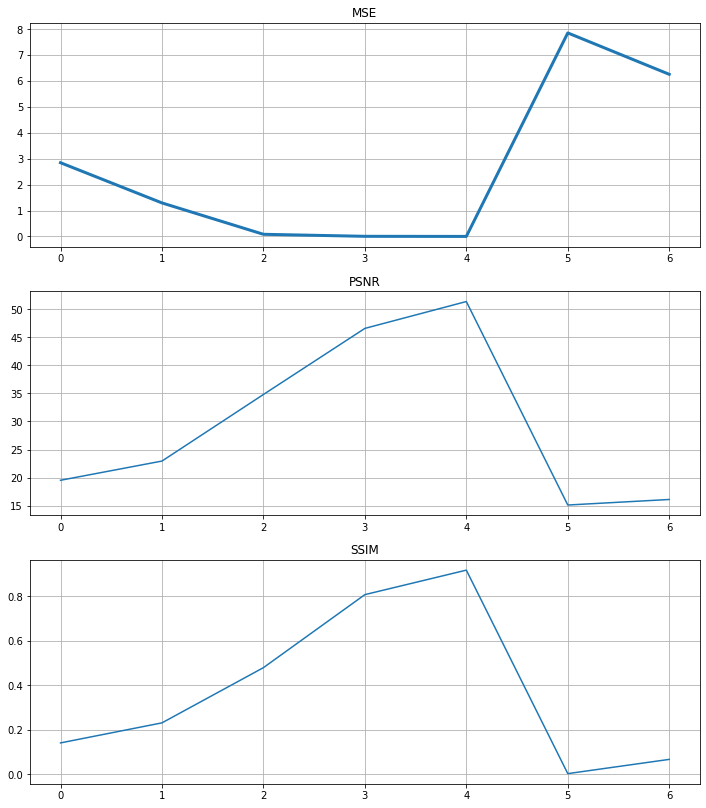

+---+-------------+-------+--------+-------+
| № | Изображение |  MSE  |  PSNR  |  SSIM |
+---+-------------+-------+--------+-------+
| 1 |      10     | 2.585 | 19.942 | 0.093 |
| 2 |      12     | 0.938 | 24.345 | 0.167 |
| 3 |      14     | 0.074 | 35.368 | 0.395 |
| 4 |      16     | 0.006 | 46.091 | 0.766 |
| 5 |      18     | 0.002 | 51.154 | 0.898 |
| 6 |     110     | 9.164 | 14.445 | 0.004 |
| 7 |     112     | 9.627 | 14.231 | 0.023 |
+---+-------------+-------+--------+-------+


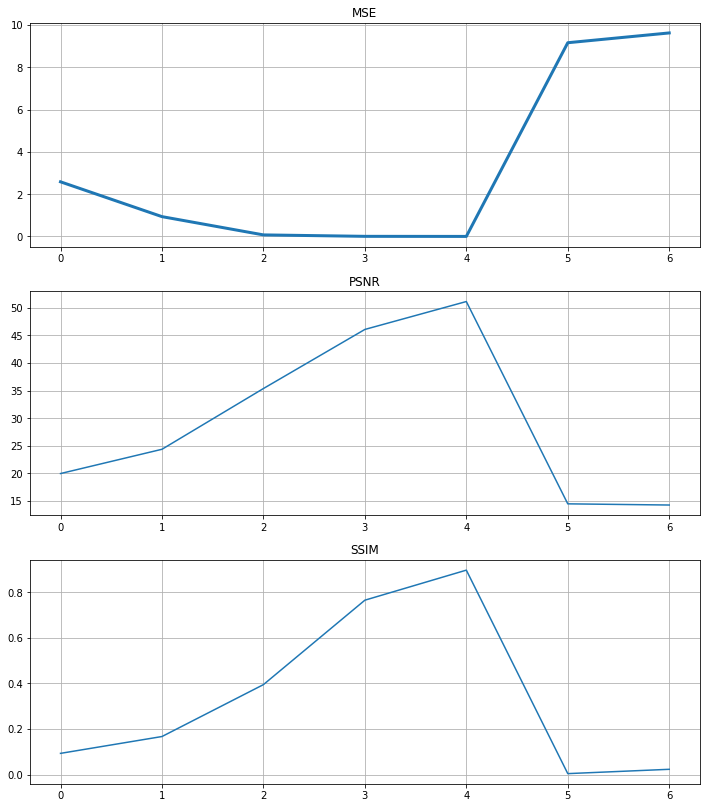

+---+-------------+-------+--------+-------+
| № | Изображение |  MSE  |  PSNR  |  SSIM |
+---+-------------+-------+--------+-------+
| 1 |      10     |  4.4  | 17.631 | 0.109 |
| 2 |      12     | 1.261 | 23.06  | 0.242 |
| 3 |      14     | 0.089 | 34.578 | 0.595 |
| 4 |      16     | 0.006 | 46.383 | 0.808 |
| 5 |      18     | 0.002 | 51.146 | 0.922 |
| 6 |     110     | 7.855 | 15.114 | 0.002 |
| 7 |     112     | 8.923 | 14.56  | 0.015 |
+---+-------------+-------+--------+-------+


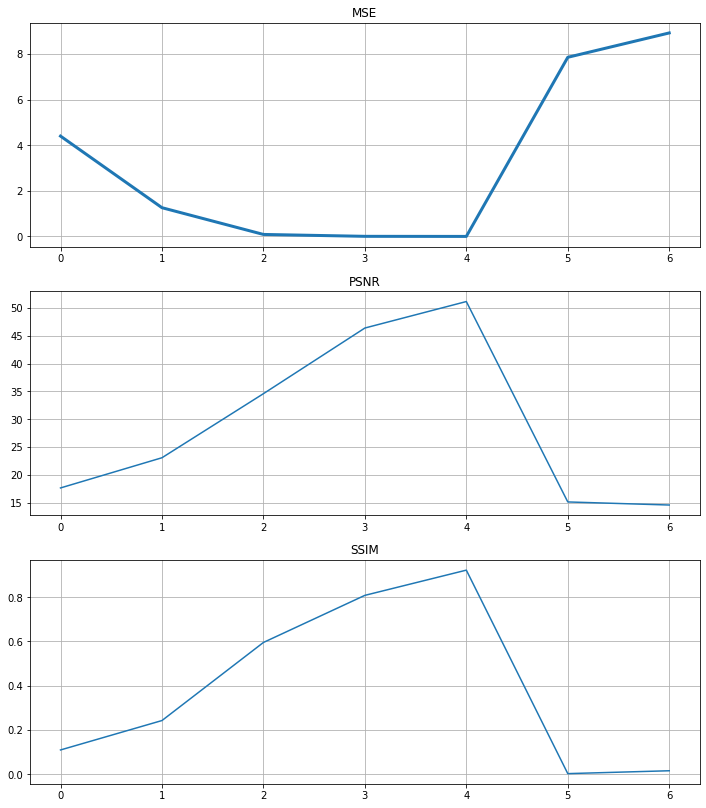

+---+-------------+-------------+---------+-------+
| № | Изображение |     MSE     |   PSNR  |  SSIM |
+---+-------------+-------------+---------+-------+
| 1 |      10     |     0.0     |   inf   |  1.0  |
| 2 |      12     |     0.0     |   inf   |  1.0  |
| 3 |      14     |     0.0     |   inf   |  1.0  |
| 4 |      16     |     0.0     |   inf   |  1.0  |
| 5 |      18     |     0.0     |   inf   |  1.0  |
| 6 |     110     | 6206527.724 | -43.863 | 0.001 |
| 7 |     112     | 6206783.111 | -43.863 |  0.01 |
+---+-------------+-------------+---------+-------+


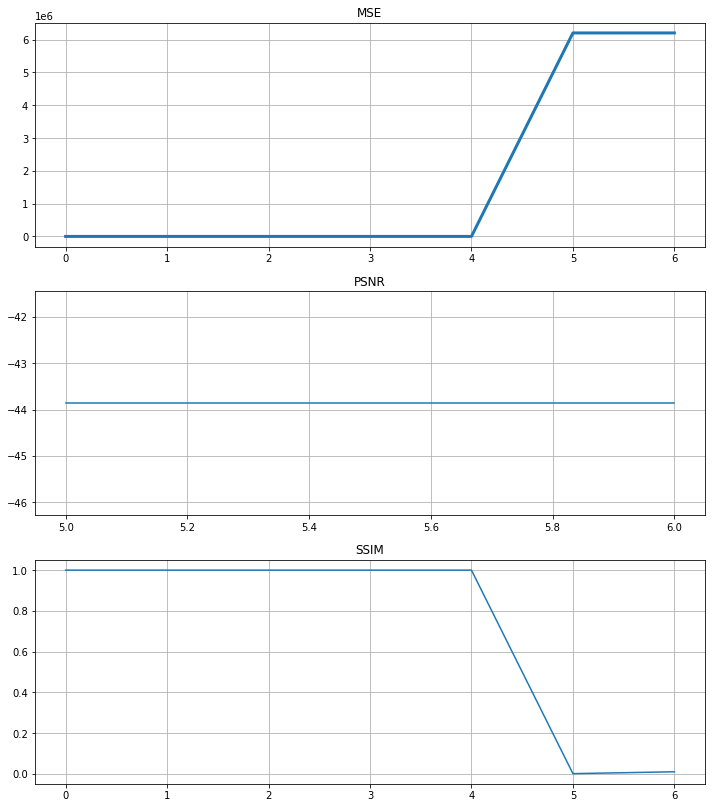

In [41]:
count_metrics(img1_q2, img1_q4, img1_q16, img1_q64, img1_q128, img1_rd, img1_cd, deffault_img=img1)

count_metrics(img2_q2, img2_q4, img2_q16, img2_q64, img2_q128, img2_rd, img2_cd, deffault_img=img2)

count_metrics(img3_q2, img3_q4, img3_q16, img3_q64, img3_q128, img3_rd, img3_cd, deffault_img=img3)

count_metrics(img4_q2, img4_q4, img4_q16, img4_q64, img4_q128, img4_rd, img4_cd, deffault_img=img4)